<h1><center>MorphLink Tutorial</center></h1>


<center>Author: Jing Huang, Chenyang Yuan, Jiahui Jiang, Jianfeng Chen, Sunil S. Badve, Yesim Gokmen-Polar, Rossana L. Segura, Xinmiao Yan, Alexander Lazar, Jianjun Gao, Michael Epstein, Linghua Wang* and Jian Hu*

### Outline
1. Installation
2. Import modules
3. Read in data
4. Image segmentation
5. Extract interpretable image features
6. Link image features with gene expression
7. Select samples for visual demonstration

### 1. Installation
To install MorphLink package you must make sure that your python version is over 3.5. If you don’t know the version of python you can check it by:

In [ ]:
import platform
platform.python_version()

Note: Because MorphLink depends on pytorch, you should make sure that torch is correctly installed.
<br>
Now you can install the current release of MorphLink by the following three ways:
#### 1.1 PyPI: Directly install the package from PyPI.

In [ ]:
pip3 install MorphLink
# Note: you need to make sure that the pip is for python3

# or we could install MorphLink by
python3 -m pip install MorphLink

# If you do not have permission (when you get a permission denied error), you should install MorphLink by
pip3 install --user MorphLink

#### 1.2 Github
Download the package from Github and install it locally:

In [ ]:
git clone https://github.com/jianhuupenn/MorphLink
cd MorphLink/MorphLink_package/
python3 setup.py install --user

#### 1.3 Anaconda
If you do not have Python3.5 or Python3.6 installed, consider installing Anaconda (see Installing Anaconda). After installing Anaconda, you can create a new environment, for example, MorphLink_env (or any name that you like).

In [ ]:
# create an environment called MorphLink_env
conda create -n MorphLink_env python=3.7.9

# activate your environment 
conda activate MorphLink_env
git clone https://github.com/jianhuupenn/MorphLink
cd MorphLink/MorphLink_package/
python3 setup.py build
python3 setup.py install
conda deactivate

### 2. Import python modules

In [1]:
import os,csv,time,re,pickle,argparse
import numpy as np
import pandas as pd
import math
import random
import numba
import anndata as ad
from anndata import AnnData,read_csv,read_text,read_mtx
import scipy
from scipy import stats
from scipy import ndimage
from scipy.sparse import issparse
import scanpy as sc
# import SpaGCN as spg
import MorphLink as mph
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from skimage import io
from skimage.util import img_as_ubyte
from skimage.measure import regionprops
from skimage.feature import graycomatrix, graycoprops, peak_local_max
from skimage.segmentation import watershed
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import imutils
import slideio
import cv2
os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = str(pow(2,40)) # os system settings
import warnings
warnings.filterwarnings("ignore")


In [2]:
mph.__version__

'1.0.0'

In [3]:
os.getcwd()

'/Users/jinghuang/Library/CloudStorage/Dropbox/Jian_Jing/LabelTransfer/test_package'

### 3. Read in data
The current version of MorphLink requres two input data: 
<br>
1. The gene expression matrix (N $\times$ G): expression_matrix.h5ad;
<br>
The gene expression data here is stored as an AnnData object. AnnData stores a data matrix .X together with annotations of observations .obs, variables .var and unstructured annotations .uns.
<br>
2. Histology image: histology.jpg (can be .tif or .png or .jpg).
<br>

In [4]:
# Set the working directory
plot_dir="." # set a data directory (need to make up folders of results, seg_results, and figures)
if not os.path.exists(plot_dir+"/figures"):
	os.mkdir(plot_dir+"/figures")


if not os.path.exists(plot_dir+"/results"):
	os.mkdir(plot_dir+"/results")


if not os.path.exists(plot_dir+"/seg_results"):
	os.mkdir(plot_dir+"/seg_results")

    


In [5]:
# Read in gene expression adata
gene_adata=sc.read("./toy_data/exp_tumor.h5ad")

# Read in histology image
img=cv2.imread("./toy_data/img_tumor.jpg")
d0, d1=img.shape[0], img.shape[1]


### 4. Image segmentation

#### 4.1 Determine patch size

- patch_size varies with datasets generated from different techniques (default value for 10x Visium is 400)

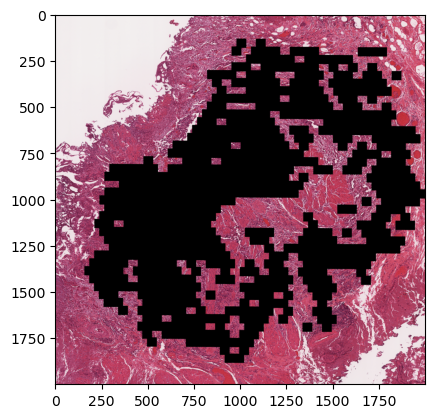

True

In [6]:
# Set the patch size
patch_size=400
half_size=patch_size/2

# spatial coordinates of spots
pixel_x=gene_adata.obs["pixel_x"].tolist()
pixel_y=gene_adata.obs["pixel_y"].tolist()

# Test the patch size 
img_new=img.copy()
for i in range(len(pixel_x)):
	x=pixel_x[i]
	y=pixel_y[i]
	img_new[int(x-half_size):int(x+half_size), int(y-half_size):int(y+half_size),:]=0


img_new=cv2.resize(img_new, (2000, 2000), interpolation = cv2.INTER_AREA)
img_new_cvt=cv2.cvtColor(img_new, cv2.COLOR_BGR2RGB)
plt.imshow(img_new_cvt)
plt.show()
# save the test patch size image
cv2.imwrite(plot_dir+'/figures/test_patch_size.jpg', img_new)


#### 4.2 Patch split

- patches: a 4D array with a shape of (N, m, m, 3), where N stands for the total number of spots and m denotes the specified patch size

In [ ]:
patches=mph.patch_split_for_ST(img=img, patch_size=patch_size, spot_info=gene_adata.obs, x_name="pixel_x", y_name="pixel_y")
# spot information
patch_info=gene_adata.obs 
patch_info["x"]=patch_info["pixel_x"]
patch_info["y"]=patch_info["pixel_y"]

# Save the splitted image patches and its patch_info
patch_info.to_csv(plot_dir+"/results/patch_info.csv")
np.save(plot_dir+"/results/patches.npy", patches)


In [6]:
patches=np.load(plot_dir+"/results/patches.npy")
patch_info=pd.read_csv(plot_dir+"/results/patch_info.csv", header=0, index_col=0)

#### 4.3 Segment each patch into masks

- n_clusters: equals to the number of masks within each patch (default value is 10) 
- refine the initial K-Means clusters by a convolution layer

In [ ]:
# Perform a K-Means clustering to divide the pixels of each image patch into clusters 
# then employ a convolution layer to refine the cluster assignment
mph.step4_Segmentation(plot_dir=plot_dir, n_clusters=10, refine=True, refine_threshold=4) # take around 2h
check_dic_list(plot_dir)


#### 4.4 Match masks across patches

- num_mask_each: the number of masks within each patch (default value is 10)
- mapping_threshold1: max single color channel difference, choose all channels
- mapping_threshold2: max single color channel difference, choose one channel

In [ ]:
# Identify shared clusters across patches based on color distance
num_mask_each=10
mapping_threshold1=30  # max single color channel difference, choose all channels
mapping_threshold2=60  # max single color channel difference, choose one channel
masks, masks_index=mph.step5_Extract_Masks(plot_dir=plot_dir, patch_size=patch_size, num_mask_each=num_mask_each, mapping_threshold1=mapping_threshold1, mapping_threshold2=mapping_threshold2)

# Plot the segmentated masks
mph.step6_Plot_Masks(plot_dir=plot_dir, d0=d0, d1=d1, masks=masks, patch_size=patch_size, mapping_threshold1=mapping_threshold1, mapping_threshold2=mapping_threshold2)


### 5. Extract interpretable image features

#### 5.1 Mask-level image features

In [7]:
num_mask_each=10
mapping_threshold1=30  # max single color channel difference, choose all channels
mapping_threshold2=60 
masks=np.load(plot_dir+"/results/masks_"+str(mapping_threshold1)+"_"+str(mapping_threshold2)+".npy")
with open(plot_dir+"/results/masks_index_"+str(mapping_threshold1)+"_"+str(mapping_threshold2)+".pkl", "rb") as f:
	masks_index = pickle.load(f)


In [ ]:
ret=mph.Extract_Whole_Mask_Features(masks, patch_info)
ret_logged=mph.Selective_Log_Transfer(ret)


In [ ]:
# print(ret_logged.head()) # mask-level image features

In [ ]:
# Save the extracted mask-level image features
ret=sc.AnnData(ret.values,obs=patch_info, var=pd.DataFrame({"feature_names":ret.columns.tolist()}))
ret.var.index=ret.var["feature_names"].tolist()
ret_logged=sc.AnnData(ret_logged.values,obs=patch_info, var=pd.DataFrame({"feature_names":ret_logged.columns.tolist()}))
ret_logged.var.index=ret_logged.var["feature_names"].tolist()
ret_logged.write_h5ad(plot_dir+"/results/mask_features_all_logged.h5ad")


#### 5.2 Object-level image features

In [ ]:
# Separate the connected components within each mask
mph.step8_CC_Detection_for_ST(plot_dir=plot_dir, patch_info=patch_info, masks_selected=masks, masks_index_selected=masks_index, details=False)

# Summarize image features for connected components by patch
labels=np.load(plot_dir+"/results/cc_no_details.npy")
channels=[i for i in range(labels.shape[0])]
ret=mph.Extract_CC_Features(labels=labels, patch_info=patch_info, channels=channels, min_area=10)
ret_logged=mph.Selective_Log_Transfer(ret)


In [ ]:
# print(ret_logged.head()) # object-level image features

In [16]:
# Save the extracted object-level image features
ret=sc.AnnData(ret.values,obs=patch_info, var=pd.DataFrame({"feature_names":ret.columns.tolist()}))
ret.var.index=ret.var["feature_names"].tolist()
ret_logged=sc.AnnData(ret_logged.values,obs=patch_info, var=pd.DataFrame({"feature_names":ret_logged.columns.tolist()}))
ret_logged.var.index=ret_logged.var["feature_names"].tolist()
ret_logged.write_h5ad(plot_dir+"/results/cc_features_all_logged.h5ad")

# Combine mask-level image features with object-level image features
sub1=sc.read(plot_dir+"/results/mask_features_all_logged.h5ad")
sub2=sc.read(plot_dir+"/results/cc_features_all_logged.h5ad")
img_adata=ad.concat([sub1, sub2], axis=1,join='inner')
img_adata.obs=sub1.obs
del sub1, sub2
img_adata.write_h5ad(plot_dir+"/results/all_features_logged.h5ad")


#### 5.3 Understand masks

- num_samples: the number of samples for each mask visualization

In [17]:
# Summarize the properties of each mask
ret=mph.mask_properity(masks, img, patch_info, d0, d1, center=True)
print(ret) 


Combining mask  0
Combining mask  1
Combining mask  2
Combining mask  3
Combining mask  4
Combining mask  5
   per_contain  per_area           avg_rgb
0        1.000     0.374  [156.  52.  90.]
1        1.000     0.345  [186.  71. 110.]
2        0.988     0.065  [242. 219. 225.]
3        1.000     0.124  [213. 116. 155.]
4        1.000     0.181     [98. 29. 64.]
5        1.000     0.072  [229. 155. 186.]


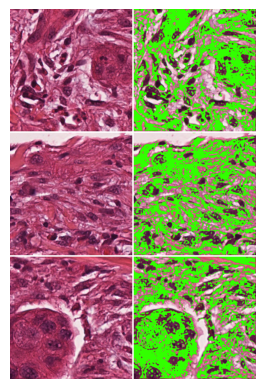

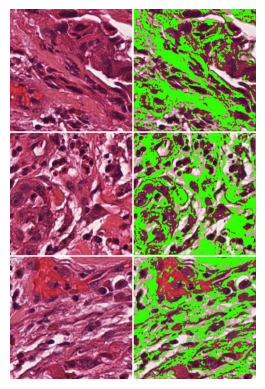

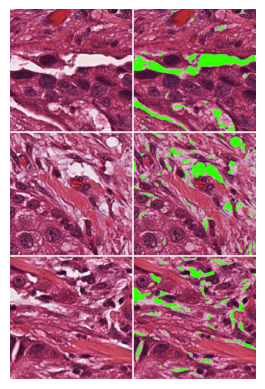

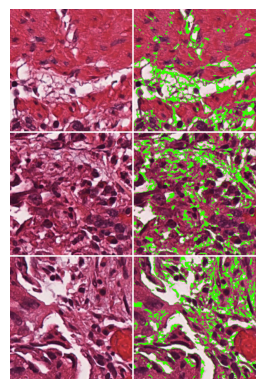

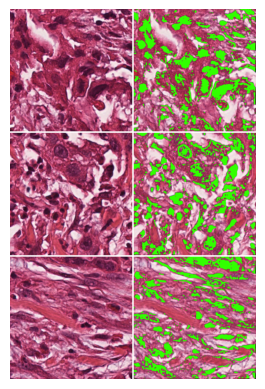

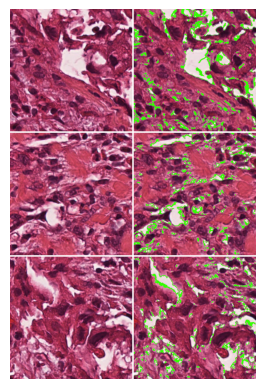

In [23]:
# Plot some sample masks for visuallization
num_samples = 3 # the number of samples for each mask
for channel in range(masks.shape[0]):
    ret_img=mph.mask_example(channel, img_adata, patch_info, patches, masks, plot_dir=plot_dir+"/figures", num_samples=num_samples, filter_mask_area=True)
    ret_img_cvt=cv2.cvtColor(ret_img, cv2.COLOR_BGR2RGB)
    plt.imshow(ret_img_cvt)
    plt.axis('off')
    plt.show()
    plt.close()
    

### 6. Link image features with gene expression

#### 6.1 Preprocessing

In [8]:
# Gene expression
gene_adata=sc.read("./toy_data/exp_tumor.h5ad")
gene_adata.X=(np.array(gene_adata.X.A) if issparse(gene_adata.X) else np.array(gene_adata.X))
sc.pp.log1p(gene_adata)

# Histology image
img_adata=sc.read(plot_dir+"/results/all_features_logged.h5ad")
img_adata.X=(img_adata.X.A if issparse(img_adata.X) else img_adata.X)
img_adata=img_adata[img_adata.obs.index.isin(gene_adata.obs.index)]
# Keep image features with over 10% non median 
img_adata=img_adata[:, np.sum(img_adata.X!=np.median(img_adata.X, 0), 0)>(img_adata.shape[0]/10)]


#### 6.2 Spatial clustering on gene expression and image features separately

Apart from louvain clustering, other spatial clustering methods (e.g., SpaGCN) can also be employed

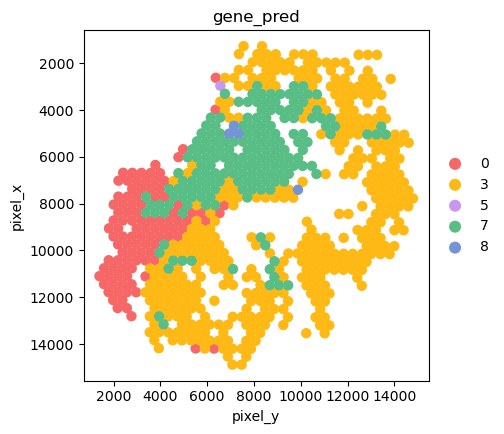

In [9]:
# Set colors
cnt_color = clr.LinearSegmentedColormap.from_list('pink_green', ['#3AB370',"#EAE7CC","#FD1593"], N=256)
cat_color=["#F56867","#FEB915","#C798EE","#59BE86","#7495D3","#D1D1D1","#6D1A9C","#15821E","#3A84E6","#997273","#787878","#DB4C6C","#9E7A7A","#554236","#AF5F3C","#93796C","#F9BD3F","#DAB370","#877F6C","#268785"]

# Gene expression
# Louvain clustering
pca = PCA(n_components=50)
pca.fit(gene_adata.X)
embed=pca.transform(gene_adata.X)
tmp=sc.AnnData(embed)
sc.pp.neighbors(tmp, n_neighbors=10)
sc.tl.louvain(tmp,resolution=0.05)
y_pred=tmp.obs['louvain'].astype(int).to_numpy()
gene_adata.obs["gene_pred"]=y_pred
# or by SpaGCN
gene_adata.obs["gene_pred"]=gene_adata.obs["spagcn_pred"].astype('category') # use the spatial clustering results from SpaGCN

# check spatial clustering of gene expression
domains="gene_pred"
num_domains=len(gene_adata.obs[domains].unique())
gene_adata.uns[domains+"_colors"]=list(cat_color[:num_domains])
ax=sc.pl.scatter(gene_adata,alpha=1,x="pixel_y",y="pixel_x",color=domains,title=domains,color_map=cat_color,show=False,size=150000/gene_adata.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()
plt.savefig(plot_dir+"/figures/gene_pred.png", dpi=600)
plt.show()
plt.close()
# ax=spg.plot_spatial_domains_ez_mode(gene_adata, domain_name="gene_pred", x_name="pixel_y", y_name="pixel_x", plot_color=cat_color, size=150000/gene_adata.shape[0], 
	# show=False, save=True,save_dir=plot_dir+"/figures/gene_pred.png")


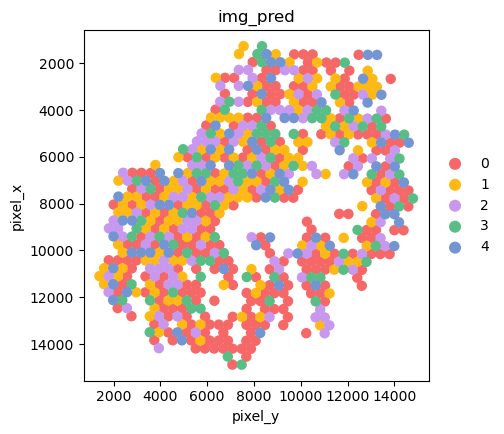

In [10]:
# Image features
# Louvain clustering
pca = PCA(n_components=50)
pca.fit(img_adata.X)
embed=pca.transform(img_adata.X)
tmp=sc.AnnData(embed)
sc.pp.neighbors(tmp, n_neighbors=10)
sc.tl.louvain(tmp,resolution=0.05)
y_pred=tmp.obs['louvain'].astype(int).to_numpy()
len(np.unique(y_pred)) # number of louvain clusters for image features
img_adata.obs["img_pred"]=y_pred
img_adata.obs["img_pred"]=img_adata.obs["img_pred"].astype('category')

# check spatial clustering of image features
domains="img_pred"
num_domains=len(img_adata.obs[domains].unique())
img_adata.uns[domains+"_colors"]=list(cat_color[:num_domains])
ax=sc.pl.scatter(img_adata,alpha=1,x="pixel_y",y="pixel_x",color=domains,title=domains,color_map=cat_color,show=False,size=150000/img_adata.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()
plt.savefig(plot_dir+"/figures/img_pred.png", dpi=600)
plt.show()
plt.close()
# ax=spg.plot_spatial_domains_ez_mode(img_adata, domain_name="img_pred", x_name="pixel_y", y_name="pixel_x", plot_color=cat_color,size=180000/img_adata.shape[0], 
	# show=False, save=True,save_dir=plot_dir+"/figures/img_pred.png")


#### 6.3 Identify subregions

In [11]:
# check spatial clustering of combined clusters
gene_clusters=gene_adata.obs["gene_pred"].tolist()
img_clusters=img_adata.obs["img_pred"].tolist()

# for any cluster pair if the overlapping spots / overall spots > max_threshod (default value is 0.2) then merge the two clusters
gene_adata.obs["combined_pred"]=mph.combine_clusters(gene_clusters, img_clusters, min_threshold=1/5, max_threshold=1/2)
gene_adata.obs["combined_pred"]=gene_adata.obs["combined_pred"].astype('category')
# ax=spg.plot_spatial_domains_ez_mode(gene_adata, domain_name="combined_pred", x_name="pixel_y", y_name="pixel_x", plot_color=cat_color,size=150000/gene_adata.shape[0], 
	# show=False, save=True,save_dir=plot_dir+"/figures/combined.png")


#### 6.4 Quantify the curve-based similarity

- genes: a set of interested genes or identified from DE analysis
- channel: the mask channel number to focus on
- w_cor: the weights for correlation (default value is 0.5)
- CPSI: Curve-based Pattern Similarity Index

In [12]:
# Specify a set of interested genes (or from DE analysis)
genes=["B2M", "CD74", "TAP1", "MKI67", "MYCL", "TUBB", "MS4A1", "IGHM"]
gene_adata_sub=gene_adata[:,gene_adata.var.index.isin(genes)].copy()

# Specify the mask channel 
channel = 4
features=[i for i in img_adata.var.index if "m"+str(channel) in i]+[i for i in img_adata.var.index if "c"+str(channel) in i]
img_adata_sub=img_adata[:,img_adata.var.index.isin(features)].copy()

# Normalize gene expression and image features to the value range of [0,1]
# gene expression
gene_df=gene_adata_sub.X.A if issparse(gene_adata_sub.X) else gene_adata_sub.X
gene_df=np.array(gene_df)
gene_df=(gene_df-np.min(gene_df, 0))/(np.max(gene_df, 0)-np.min(gene_df, 0))
# image features
img_df=img_adata_sub.X.A if issparse(img_adata_sub.X) else img_adata_sub.X
img_df=np.array(img_df)
img_df=(img_df-np.min(img_df, 0))/(np.max(img_df, 0)-np.min(img_df, 0))

# spatial coordinates of spots
x = gene_adata_sub.obs["pixel_x"].values
y = gene_adata_sub.obs["pixel_y"].values

# Measure the regional pattern similarity
clusters=[0]*len(x)
cor=mph.pattern_similarity(gene_df, img_df, clusters, x, y, num_interval=20, method="mean", metric="cor", integrate_xy="weighted",pool="min", rescale=True, add_noise=True, two_side=False, min_spots=5)
diff=mph.pattern_similarity(gene_df, img_df, clusters, x, y, num_interval=20, method="mean", metric="diff", integrate_xy="weighted",pool="max", rescale=True, add_noise=True, two_side=False, min_spots=5)
cor=pd.DataFrame(cor, index=gene_adata_sub.var.index, columns=img_adata_sub.var.index)
diff=pd.DataFrame(diff, index=gene_adata_sub.var.index, columns=img_adata_sub.var.index)
# assign weights to correlation (default value is 0.5)
w_cor=1/2
CPSI=w_cor*cor+(1-w_cor)*(1-diff)

# take gene CD74 as an example
# identify 10 image features that share the highest regional pattern similarity with the specified gene
g="CD74" # from the list of genes
CPSI.loc[g, :].nlargest(10)


c4_solidity_iqr            0.725101
log_c4_solidity_std        0.698598
log_c4_dis_iqr             0.443087
log_c4_extent_iqr          0.428348
log_c4_extent_std          0.408181
log_c4_dis_std             0.405402
log_c4_extent_q0           0.402305
log_c4_extent_q100         0.396058
c4_eccentricity_q0         0.394627
log_m4_Dist_Trans_1_std    0.384034
Name: CD74, dtype: float64

#### 6.5 Generate marginal curves

c4_solidity_iqr
CD74
[0.13, 0.15, 0.162, 0.176, 0.196]
[0.63, 0.576, 0.816, 1.047, 0.901]
[0.13, 0.63, 0.15, 0.576, 0.162, 0.816, 0.176, 1.047, 0.196, 0.901]


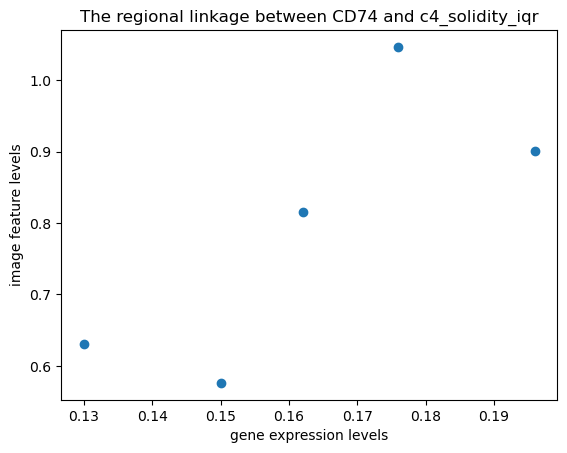

In [13]:
# for a pair of gene expression feature and image feature
g="CD74"
f=CPSI.loc[g, :].nlargest(1).index.tolist()[0] # select the image feature with the highest regional pattern similarity
print(f)

# Gradient changes along x-axis and y-axis
range_step=1/4
num_cuts=5

img_adata_sub.obs[g]=np.array(gene_adata_sub.X)[:, gene_adata_sub.var.index==g]
img_adata_sub.obs[f]=np.array(img_adata_sub.X)[:, img_adata_sub.var.index==f]
x, y, z=[], [], []
for i in range(num_cuts):
	mx=np.quantile(img_adata_sub.obs[f], i/num_cuts+1/num_cuts*(1-range_step))
	mi=np.quantile(img_adata_sub.obs[f], i/num_cuts+1/num_cuts*range_step)
	sub_tmp=img_adata_sub[(img_adata_sub.obs[f]>=mi)&(img_adata_sub.obs[f]<=mx),:]
	median_f=np.median(sub_tmp.obs[f])
	samples=sub_tmp.obs.index[(sub_tmp.obs[f]>=mi) & (sub_tmp.obs[f]<=mx)].tolist()
	x.append(np.round(np.mean(sub_tmp.obs[f]), 3))
	y.append(np.round(np.mean(sub_tmp.obs[g]), 3))
	z.append(np.round(np.mean(sub_tmp.obs[f]), 3))
	z.append(np.round(np.mean(sub_tmp.obs[g]), 3))

print(g)
print(x)
print(y)
print(z)

# generate a scatter plot for x and y
plt.scatter(x, y)
plt.xlabel("gene expression levels")
plt.ylabel("image feature levels")
plt.title("The regional linkage between "+g+" and "+f)
plt.show()
plt.close()


### 7. Select samples for visual demonstration

- num_sample: the number of samples for demonstrating the linkage between the pair of gene expression feature and image feature

In [15]:
labels=np.load(plot_dir+"/results/cc_no_details.npy")

In [17]:
# Load in the generated patch_info, patches, and labels
# plot_dir="."
# patch_info=pd.read_csv(plot_dir+"/results/patch_info.csv", header=0, index_col=0)
# patches=np.load(plot_dir+"/results/patches.npy")
# labels=np.load(plot_dir+"/results/cc_no_details.npy")

# Specify a set of interested image features
target_features = [f]
visual_img_list = []
num_sample=5

for f in target_features:
	if not os.path.exists(plot_dir+"/figures/"+f):
		os.mkdir(plot_dir+"/figures/"+f)
	visual_img=mph.sample_illustration(f, img_adata_sub, patch_info, patches, labels, plot_dir=plot_dir+"/figures/"+f, num_cuts=num_cuts, range_step=range_step, num_sample=num_sample, filter_mask_area=True, filter_cc_q100=False)
	visual_img_list.append(visual_img)



channel 4 f_type c
AACGTTAGTCACAACT-1     9.332027
AACTGCTTCTGTTGAC-1    10.153273
AATCGGAACGTAGAGC-1    10.278631
ACAACGGATTGGAGTG-1    10.403262
ACAACTATTCGAGGTA-1    10.445056
                        ...    
TGGCTCTAAGCGACGG-1     9.360053
TGGTCTTCTGATTAGA-1    10.365018
TGTACCAAGTTGGTAA-1    10.849007
TGTATGATCGTTAACC-1     8.885441
TGTCAGGTTAATGCAA-1    10.380715
Name: mask_area, Length: 66, dtype: float64
Cut 0, median=0.13001048133495624
Num of samples =  5
AACAGGCCATTGTCAC-1     9.263976
AACGGTCGTATTAGGC-1    10.355423
AAGCACTCGTTCGCCA-1    10.590793
AAGCAGATCATAATGT-1     9.836653
AATTCAAGGCACGATC-1    10.517592
                        ...    
TGGACGTGCGATTCGG-1    10.336373
TGGTATGTATGGAGTC-1    10.311383
TGGTGCTCTACTTGAA-1    10.363788
TGTCAACACTTCAGTT-1    10.319893
TGTCGACGCACCGTGG-1    10.224846
Name: mask_area, Length: 67, dtype: float64
Cut 1, median=0.1494131139072774
Num of samples =  5
AACATATGCACTTCTA-1    10.354691
AACGGCGACGTCCACC-1    10.410124
AAGGCGTGGTATGGCT-1

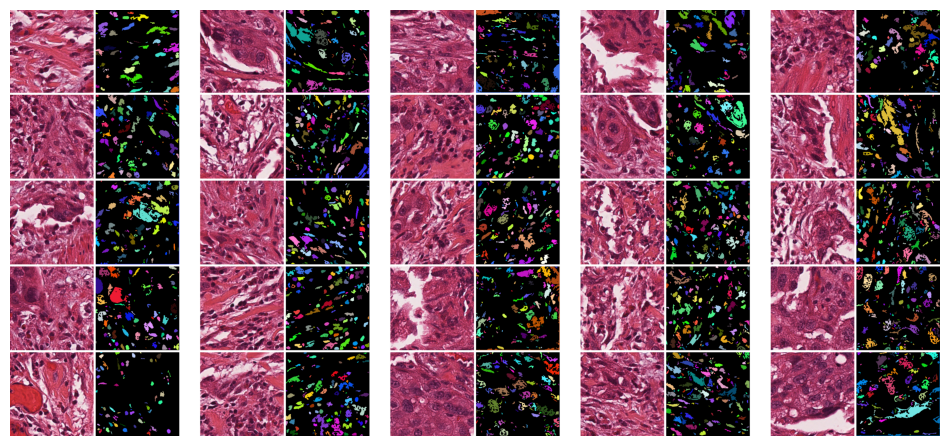

In [22]:
# Generate sample linkage visual demonstration
for i in range(len(visual_img_list)):
    visual_img=visual_img_list[i]
    visual_img_cvt=cv2.cvtColor(visual_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12,36))
    plt.imshow(visual_img_cvt)
    plt.axis('off')
    plt.show()
    plt.close()
    
